<a href="https://colab.research.google.com/github/weiyuchen1213/Active-Learning/blob/master/Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install modAL

In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "weiyuchen77" # username from the json file
os.environ['KAGGLE_KEY'] = "2f37118812a2fab44b6a6853616f9fa7" # key from the json file
!kaggle datasets download -d aungpyaeap/fish-market # api copied from kaggle
!kaggle datasets download -d uciml/mushroom-classification # api copied from kaggle
!kaggle datasets download -d uciml/iris # api copied from kaggle
!kaggle datasets download -d uciml/glass # api copied from kaggle

  0% 0.00/2.39k [00:00<?, ?B/s]
100% 2.39k/2.39k [00:00<00:00, 4.33MB/s]
  0% 0.00/34.2k [00:00<?, ?B/s]
100% 34.2k/34.2k [00:00<00:00, 33.5MB/s]
  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 3.43MB/s]
  0% 0.00/3.42k [00:00<?, ?B/s]
100% 3.42k/3.42k [00:00<00:00, 5.17MB/s]


In [4]:
!unzip fish-market.zip
!unzip mushroom-classification.zip
!unzip iris.zip
!unzip glass.zip

Archive:  fish-market.zip
  inflating: Fish.csv                
Archive:  mushroom-classification.zip
  inflating: mushrooms.csv           
Archive:  iris.zip
  inflating: Iris.csv                
  inflating: database.sqlite         
Archive:  glass.zip
  inflating: glass.csv               


In [5]:
import pandas as pd
fish = pd.read_csv('Fish.csv')
mushroom = pd.read_csv('mushrooms.csv')
iris = pd.read_csv('Iris.csv')
iris = iris.drop('Id',axis=1)
glass = pd.read_csv('glass.csv')

https://stackoverflow.com/questions/34915813/convert-text-columns-into-numbers-in-sklearn

https://www.w3resource.com/machine-learning/scikit-learn/iris/python-machine-learning-k-nearest-neighbors-algorithm-exercise-3.php


In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
iris.Species = le.fit_transform(iris.Species)
fish.Species = le.fit_transform(fish.Species)

# Converting string labels into numbers.
mushroom = mushroom[mushroom.columns[:]].apply(le.fit_transform)

In [7]:
# fish
X_fish = fish.drop('Species', axis=1)
y_fish = fish['Species']

#mushrooms
X_mushroom = mushroom.drop('class', axis=1)
y_mushroom = mushroom['class']

# iris
X_iris = iris.drop('Species', axis=1)
y_iris = iris['Species']

# glass
X_glass = glass.drop('Type', axis=1)
y_glass = glass['Type']

In [8]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

# iris

In [9]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [10]:
from sklearn.datasets import load_iris

#iris = load_iris()
X_raw = X_iris.values
y_raw = y_iris.values
#iris

In [11]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

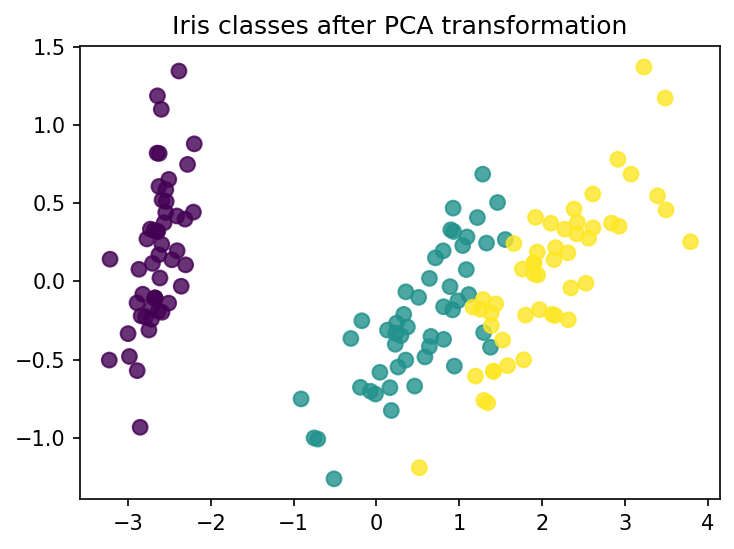

In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(5.5, 4), dpi=150)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [14]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner,BayesianOptimizer

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [16]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

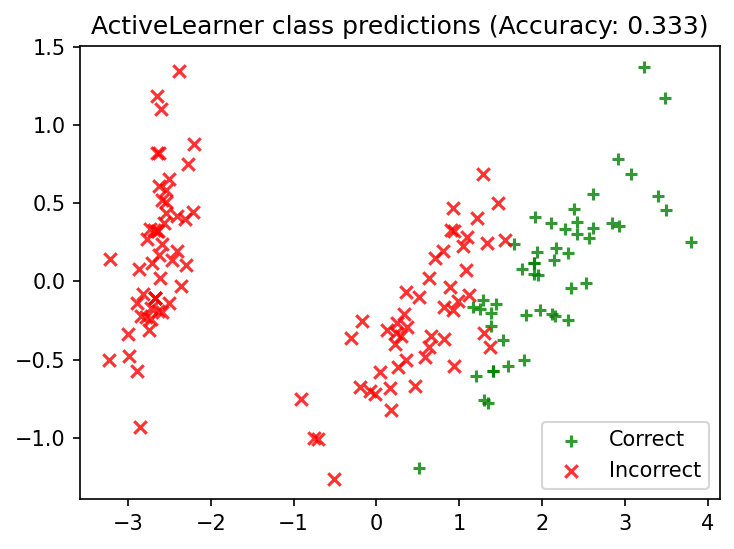

<Figure size 432x288 with 0 Axes>

In [18]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

plt.savefig('ActiveLearner class predictions',dpi=300)

In [19]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


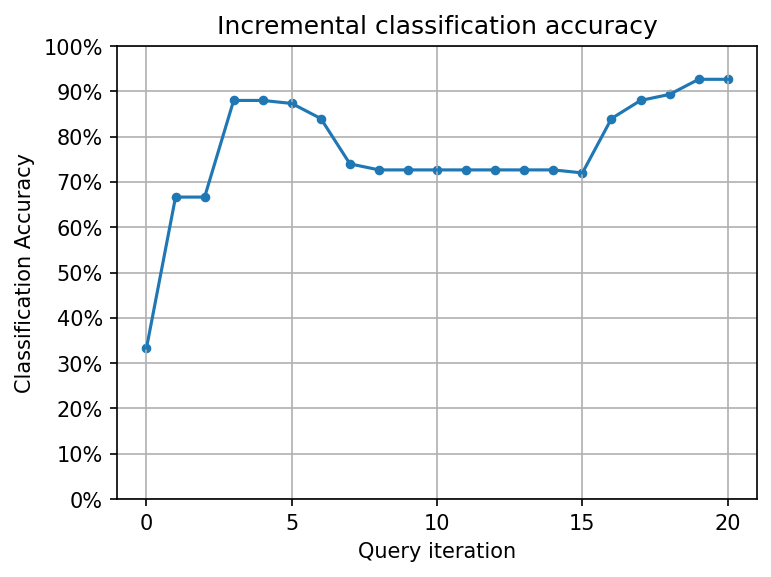

In [20]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()


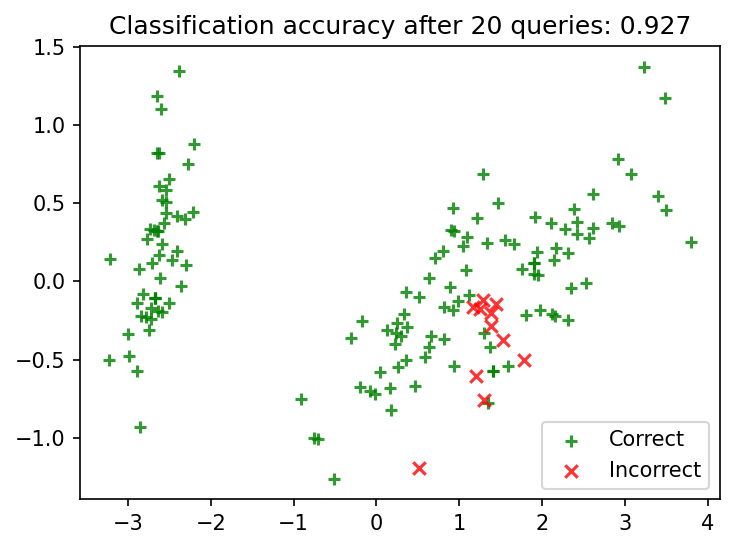

<Figure size 432x288 with 0 Axes>

In [21]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()


In [ ]:
from modAL.models import  ActiveLearner, BayesianOptimizer, Committee, CommitteeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

X_train, y_train = X_iris.values, y_iris.values

learner = BayesianOptimizer(estimator=RandomForestClassifier())
scores_iris = cross_val_score(learner, X_train, y_train, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [ ]:
scores_iris.mean()

0.9400000000000001

# glass

In [22]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [23]:
X_raw = X_glass.values
y_raw = y_glass.values

In [24]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_glass = pca.fit_transform(X=X_raw)

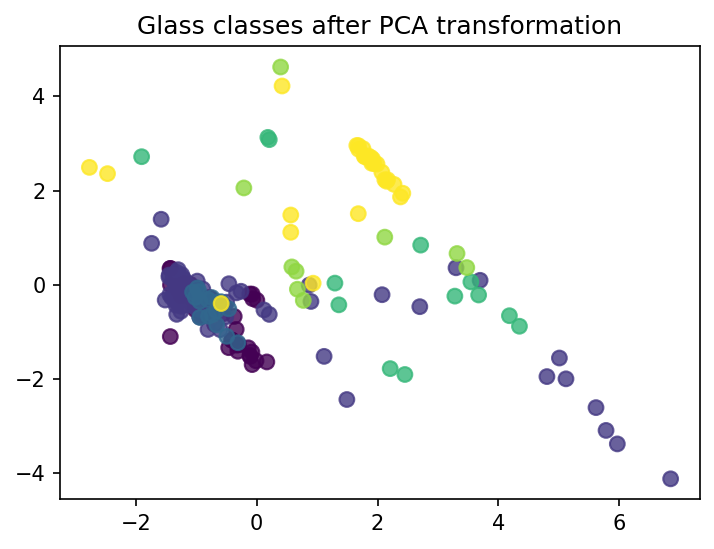

In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_glass[:, 0], transformed_glass[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(5.5, 4), dpi=150)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Glass classes after PCA transformation')
plt.show()


In [27]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=6)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner,BayesianOptimizer

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=RandomForestClassifier(n_estimators=200), X_training=X_train, y_training=y_train)

In [29]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

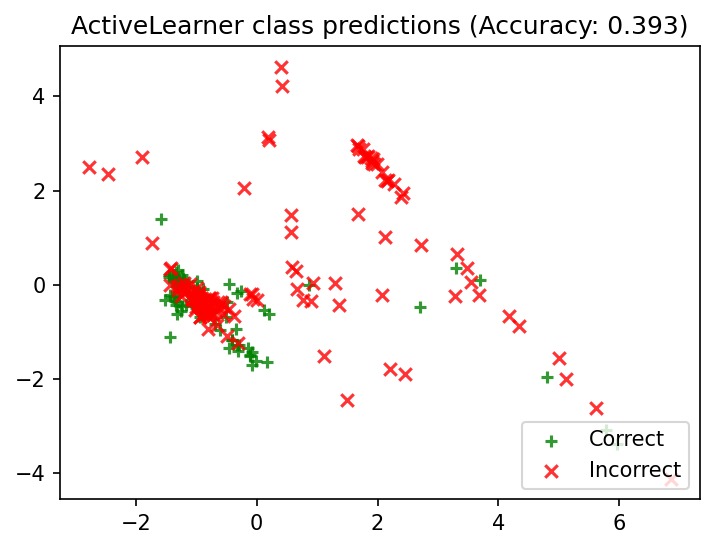

<Figure size 432x288 with 0 Axes>

In [30]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()


In [31]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.3785
Accuracy after query 2: 0.4159
Accuracy after query 3: 0.4112
Accuracy after query 4: 0.4299
Accuracy after query 5: 0.4252
Accuracy after query 6: 0.4346
Accuracy after query 7: 0.4439
Accuracy after query 8: 0.4439
Accuracy after query 9: 0.4486
Accuracy after query 10: 0.4393
Accuracy after query 11: 0.4486
Accuracy after query 12: 0.4579
Accuracy after query 13: 0.4626
Accuracy after query 14: 0.4813
Accuracy after query 15: 0.4907
Accuracy after query 16: 0.5794
Accuracy after query 17: 0.5841
Accuracy after query 18: 0.5981
Accuracy after query 19: 0.6075
Accuracy after query 20: 0.6121


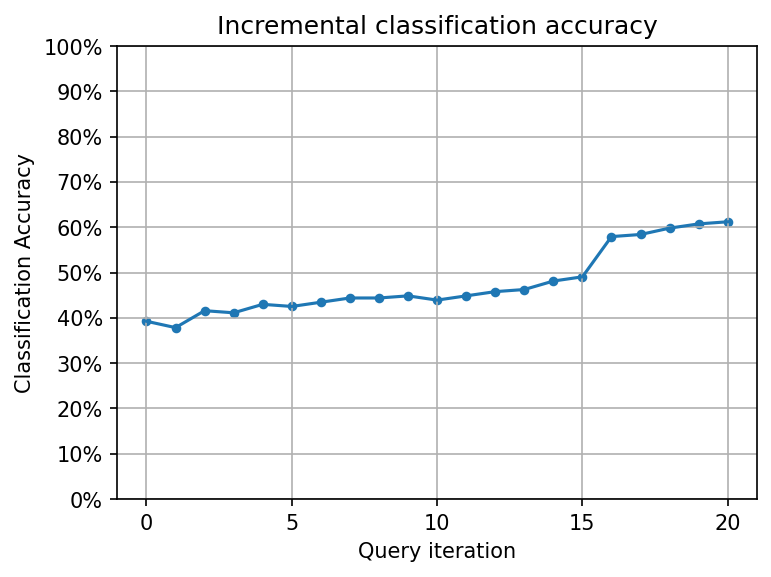

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

plt.savefig('Incremental classification accuracy',dpi=130)

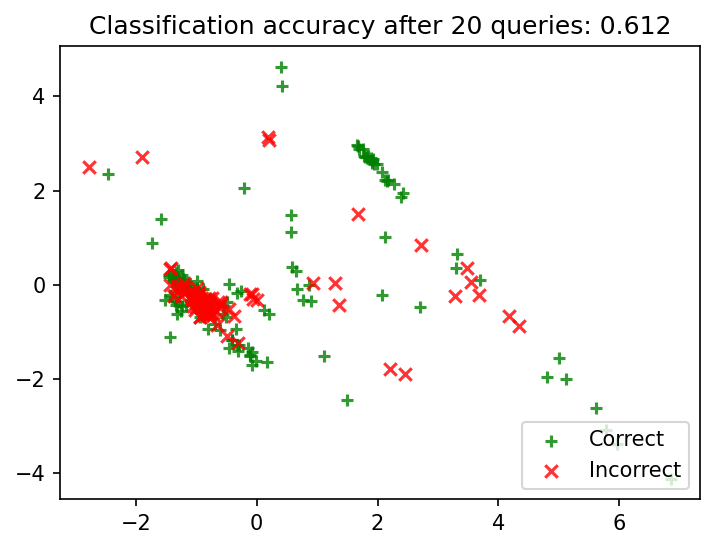

<Figure size 432x288 with 0 Axes>

In [33]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(5.5, 4), dpi=150)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

plt.savefig('Classification accuracy after 20 queries',dpi=130)

In [ ]:
from modAL.models import  ActiveLearner, BayesianOptimizer, Committee, CommitteeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

X_train, y_train = X_glass.values, y_glass.values

learner = ActiveLearner(estimator=RandomForestClassifier())
scores_glass = cross_val_score(learner, X_train, y_train, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [ ]:
scores_glass.mean()

0.5621212121212122